In [1]:
from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
from bokeh.plotting import figure, show, output_file, save
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
from bokeh.palettes import Viridis, Category10, Category20
from bokeh.io import export_svg
from tqdm import tqdm
output_notebook()

Loading BokehJS ...

In [2]:
from metamod.tasks import TaskSwitch, AffineCorrelatedGaussian, CompositionOfTasks, SemanticTask, MNIST
from metamod.trainers import two_layer_training, two_layer_engage_training
from metamod.networks import LinearNet, LinearCatPropNet
from metamod.control import CatPropControl, LinearNetEq
from metamod.utils import plot_lines

Loading BokehJS ...

In [3]:
run_name = "cat_prop"
results_path = "../results"
results_dict = {}

In [4]:
dataset_params = {"batch_size": 16,
                  "h_levels": 2}

dataset = SemanticTask(**dataset_params)

In [5]:
model_params = {"learning_rate": 5e-3,
                "hidden_dim": 10,
                "intrinsic_noise": 0.0,
                "reg_coef": 0.0,
                "input_dim": dataset.input_dim,
                "output_dim": dataset.output_dim,
                "W1_0": None,
                "W2_0": None}

model_params["input_dim"] = dataset.input_dim
model_params["output_dim"] = dataset.output_dim

model_params["W1_0"] = np.random.normal(scale=1e-4,
                                        size=(model_params["hidden_dim"], model_params["input_dim"]))
model_params["W2_0"] = np.random.normal(scale=1e-4,
                                        size=(model_params["output_dim"], model_params["hidden_dim"]))

model = LinearCatPropNet(**model_params)

In [6]:
n_steps = 5000
save_weights_every = 20

iters, loss, weights_iter, weights = two_layer_engage_training(model=model, dataset=dataset, n_steps=n_steps, save_weights_every=save_weights_every)

results_dict["iters"] = iters
results_dict["Loss_t_sim"] = loss
results_dict["weights_sim"] = weights
results_dict["weights_iters_sim"] = weights_iter

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1012.70it/s]


In [7]:
init_W1 = weights[0][0, ...]
init_W2 = weights[1][0, ...]

init_weights = [init_W1, init_W2]
input_corr, output_corr, input_output_corr, expected_y, expected_x = dataset.get_correlation_matrix()

time_span = np.arange(0, len(iters))*model_params["learning_rate"]
results_dict["time_span"] = time_span

In [8]:
equation_params = {"in_cov": input_corr,
                   "out_cov": output_corr,
                   "in_out_cov": input_output_corr,
                   # "expected_y": expected_y,
                   # "expected_x": expected_x,
                   "init_weights": init_weights,
                   "n_steps": n_steps,
                   "reg_coef": model_params["reg_coef"],
                   "intrinsic_noise": model_params["intrinsic_noise"],
                   "learning_rate": model_params["learning_rate"],
                   "time_constant": 1.0}

In [9]:
solver = LinearNetEq(**equation_params)

In [10]:
control_params = {**equation_params,
                  "control_lower_bound": 0.0,
                  "control_upper_bound": 2.0,
                  "gamma": 0.99,
                  "cost_coef": 5.0,
                  "reward_convertion": 1.0,
                  "init_g": None,
                  "control_lr": 1.0}

In [11]:
control = CatPropControl(**control_params)

In [12]:
W1_t, W2_t = solver.get_weights(time_span, get_numpy=True)
Loss_t = solver.get_loss_function(W1_t, W2_t, get_numpy=True)

results_dict["W1_t_eq"] = W1_t
results_dict["W2_t_eq"] = W2_t
results_dict["Loss_t_eq"] = Loss_t

In [13]:
W1_t_control, W2_t_control = control.get_weights(time_span, get_numpy=True)
Loss_t_control = control.get_loss_function(W1_t_control, W2_t_control, get_numpy=True)

results_dict["W1_t_control_init"] = W1_t_control
results_dict["W2_t_control_init"] = W2_t_control
results_dict["Loss_t_control_init"] = Loss_t_control
results_dict["init_engagement_coef"] = control.engagement_coef.detach()

In [14]:
losses = (loss, Loss_t, Loss_t_control)
colors = (Category10[10][0], Category10[10][0], Category10[10][1])
legends = ("Real Non-linear", "Approximation", "Init Control")
alphas = (0.3, 1, 1)

s = plot_lines(iters, losses, legends, alphas, colors)
show(s)

In [15]:
iter_control = 100
control_params["iters_control"] = iter_control
cumulated_reward = []

In [16]:
for i in tqdm(range(iter_control)):
    R = control.train_step(get_numpy=True)
    # print("cumulated reward:", R)
    cumulated_reward.append(R)
cumulated_reward = np.array(cumulated_reward).astype(float)
results_dict["cumulated_reward_opt"] = cumulated_reward

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:26<00:00,  5.06s/it]


In [17]:
opt = plot_lines(np.arange(iter_control), (cumulated_reward,), x_axis_label="gradient steps on control", y_axis_label="Cumulated reward")
show(opt)

In [18]:
W1_t_opt, W2_t_opt = control.get_weights(time_span, get_numpy=True)
Loss_t_opt = control.get_loss_function(W1_t_opt, W2_t_opt, get_numpy=True)

results_dict["W1_t_control_opt"] = W1_t_opt
results_dict["W2_t_control_opt"] = W2_t_opt
results_dict["Loss_t_control_opt"] = Loss_t_opt


In [19]:
losses = (loss, Loss_t, Loss_t_opt)
colors = (Category10[10][0], Category10[10][0], Category10[10][1])
legends = ("Real Non-linear", "Approximation", "Approximated Optimized Control")
alphas = (0.3, 1, 1)

s = plot_lines(iters, losses, legends, alphas, colors)
show(s)

In [20]:
control.engagement_coef.shape

torch.Size([5000, 3])

In [21]:
phis = [control.engagement_coef[:, i].detach().cpu().numpy() for i in range(control.engagement_coef.shape[1])]
colors = [Category10[10][i] for i in range(control.engagement_coef.shape[1])]
legends = ["C"+str(i) for i in range(control.engagement_coef.shape[1])]

s = plot_lines(iters, phis, labels=legends)
show(s)

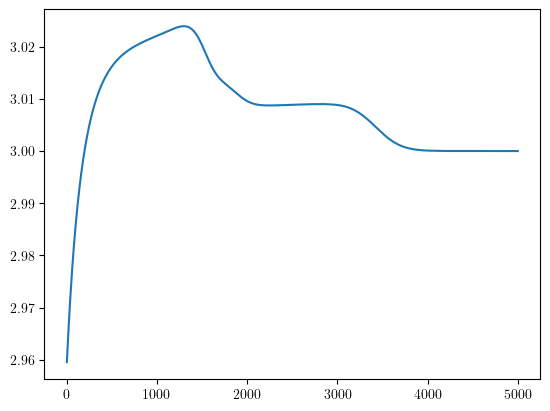

In [22]:
import matplotlib.pyplot as plt
plt.plot(np.sum(control.engagement_coef.detach().cpu().numpy(), axis=-1))

In [23]:
W1_0, W2_0 = control_params["init_weights"]

reset_model_params = model_params.copy()
reset_model_params["W1_0"] = W1_0
reset_model_params["W2_0"] = W2_0

reset_model = LinearCatPropNet(**reset_model_params)

In [24]:
iters, loss_OPT, weights_iter_OPT, weights_OPT = two_layer_engage_training(model=reset_model, dataset=dataset,
                                                                           n_steps=n_steps,
                                                                           save_weights_every=save_weights_every,
                                                                           engagement_coefficients=control.engagement_coef.detach())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 927.85it/s]


In [25]:
results_dict["Loss_t_sim_OPT"] = loss_OPT
results_dict["weights_sim_OPT"] = weights_OPT
results_dict["weights_iters_sim_OPT"] = weights_iter_OPT
results_dict["iters_OPT"] = iters

equation_params["solver"] = solver
control_params["control"] = control
dataset_params["dataset"] = dataset
model_params["model"] = model
reset_model_params["model"] = reset_model

params_dict = {"dataset_params": dataset_params,
               "model_params": model_params,
               "equation_params": equation_params,
               "control_params": control_params,
               "reset_model_params": reset_model_params}

In [26]:
losses = (loss, Loss_t, Loss_t_opt, loss_OPT)
colors = (Category10[10][0], Category10[10][0], Category10[10][1], Category10[10][1])
legends = ("Real Non-linear", "Approximation", "Approximated Optimized Control", "Optimized Non-linear")
alphas = (0.3, 1, 1, 0.3)

s = plot_lines(iters, losses, legends, alphas, colors)
show(s)